In [1]:
# change dir because notebook is in a child directory of the root directory (and does not find my modules)
import os 
try:
    os.chdir(r'/Users/joan/code/python/jokes-app')
except FileNotFoundError:
    os.chdir(r'/home/repos/joke-app')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import src.api.src.db.core as db
try:
    from src.api.src.db.secret import (
        HOST_OVH as HOST, 
        POSTGRES_USER, 
        POSTGRES_PASSWORD_OVH as POSTGRES_PASSWORD, 
        SCHEMA_NAME
    )
except ImportError:
    from src.api.src.db.secret import HOST, POSTGRES_USER, POSTGRES_PASSWORD, SCHEMA_NAME

### Get connection to Postgres DB

In [4]:
conn = db.connect(host=HOST, user=POSTGRES_USER, password=POSTGRES_PASSWORD, schema_name=SCHEMA_NAME)

### Get Number of subscribed users and unsubscribed users

In [5]:
df = db.execute_read(conn, "select * from users_mail")

In [6]:
n_subbed = df["deleted_at"].isna().sum()
n_unsubbed = len(df) - n_subbed

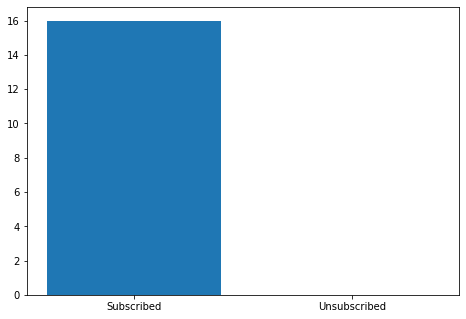

In [7]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
l_bars = ['Subscribed', 'Unsubscribed']
ax.bar(l_bars, [n_subbed, n_unsubbed])
plt.show()

### Top 10 Joke reviewers

In [8]:
df_mean_user = db.execute_read(conn, """
select 
	um.email, avg(r.rating), count(r)
from 
	ratings as r
left join users_mail as um
on (r.user_id = um.id_hash)
where "source" = 'mail' and um.email is not null
group by um.email
order by count(r.rating) desc
""")

In [23]:
df_mean_user.head(20)

,email,avg,count
0,watxaut@gmail.com,6.785714,21
1,irene.chausse@mosaicfactor.com,5.166667,15
2,antoni.martinezlopez@ficosa.com,3.214286,14
3,jaime.conde@ficosa.com,2.000000,10
4,18mariaff@gmail.com,6.000000,10
5,adria.hr@gmail.com,2.916667,6
6,guillem.mcid@gmail.com,6.666667,6
7,Extern.javier.gris@seat.es,5.833333,6
8,alex.colomer.puig@gmail.com,4.166667,6
9,Javier.heras@volkswagen-groupservices.com,5.000000,6


In [34]:
most_not_hater = df_mean_user["email"].iloc[df_mean_user["avg"].idxmax()]
most_hater = df_mean_user["email"].iloc[df_mean_user["avg"].idxmin()]
print("Most Cheerleader: '{}'\nMost Hater: '{}'".format(most_not_hater, most_hater))

Most Cheerleader: 'neuscuadernpuig@gmail.com'
Most Hater: 'marccampmanygarcia@gmail.com'


### AVG joke rating per user

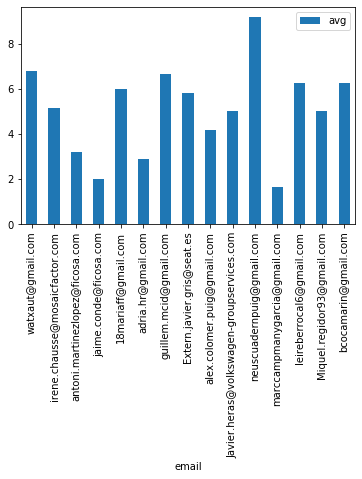

In [11]:
df_mean_user.head(20).plot.bar(x="email", y="avg")

### Rating Statistics

In [17]:
sql = """
select 
	sj.joke_id, r.rating, sj.created_at, r.created_at as voted_at
from
	sent_jokes as sj
left join 
	ratings as r
on 
	(r.joke_id = sj.joke_id)
where 
	r."source" = 'mail'
"""
df_ratings = db.execute_read(conn, sql)

#### Get last 10 ratings

In [18]:
df_ratings.tail(15)

,joke_id,rating,created_at,voted_at
97,1002,0.0,2019-11-12 08:30:24.086916,2019-11-12 07:30:21.323465
98,1002,5.0,2019-11-12 08:30:24.086916,2019-11-12 07:31:18.314594
99,1002,7.5,2019-11-12 08:30:24.086916,2019-11-12 07:30:21.820252
100,556,5.0,2019-11-13 08:30:25.447518,2019-11-13 07:35:24.109028
101,556,7.5,2019-11-13 08:30:25.447518,2019-11-13 11:14:03.994035
102,556,0.0,2019-11-13 08:30:25.447518,2019-11-13 10:27:57.274391
103,556,0.0,2019-11-13 08:30:25.447518,2019-11-13 10:16:06.327664
104,556,0.0,2019-11-13 08:30:25.447518,2019-11-13 08:21:55.818447
105,556,5.0,2019-11-13 08:30:25.447518,2019-11-13 08:13:50.577036
106,556,0.0,2019-11-13 08:30:25.447518,2019-11-13 08:09:44.835753


### Get mean of ratings by joke and day

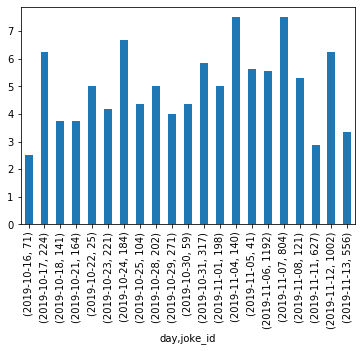

In [19]:
df_ratings["day"] = df_ratings["created_at"].dt.strftime('%Y-%m-%d')
df_ratings.groupby(["day", "joke_id"])["rating"].mean().plot.bar(x="day", y="rating")

### Get Std Deviation of ratings by joke and day

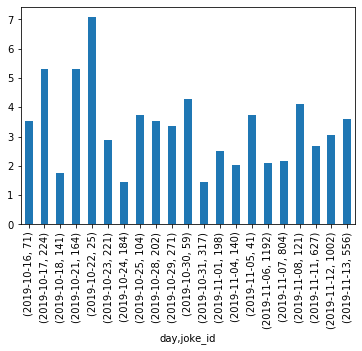

In [20]:
df_ratings.groupby(["day", "joke_id"])["rating"].std().plot.bar(x="day", y="rating")